### Physician Inital Assessments: Survival Analysis
* Applies Bayesian Inference to simulated time to physician initial assessments

### References
* https://docs.pymc.io/notebooks/bayes_param_survival_pymc3.html
* https://gist.github.com/AustinRochford/afe6862e622c31494b2f
* https://stackoverflow.com/questions/22015055/survival-analysis-in-pymc-3

In [60]:
%matplotlib inline

In [61]:
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
import pandas as pd
from theano import tensor as T
from pomegranate import *

### Simulate physician initial assessments: structure consists of the following:
   * poisson distributed data to model time in mimutes

In [62]:
N = 300

np.sum(np.random.binomial(1, 0.3, 100))
N_low = int(N*np.sum(np.random.binomial(1, 0.7, 100))/100)

rand_curve = np.random.poisson(25, int(0.3*N_low))#
rand_curve = np.concatenate((rand_curve,np.random.poisson(40, int(0.4*N_low))))
rand_curve = np.concatenate((rand_curve,np.random.poisson(50, int(0.3*N_low))))

inital_time = np.round(rand_curve, 0).astype(int)
assessment = np.random.binomial(1, 0.85, len(rand_curve))
hrt_rate = np.random.normal(70, 5, len(rand_curve))

PIA_low = pd.DataFrame({'time':inital_time,'assessment':assessment,'acuity':0,'hrt_rate':hrt_rate})

N_high = N-N_low
rand_curve = np.random.poisson(10, N_high)
inital_time = np.round(rand_curve, 0).astype(int)
assessment = np.random.binomial(1, 0.95, N_high)
hrt_rate = np.random.normal(85, 10, N_high)

PIA_high = pd.DataFrame({'time':inital_time,'assessment':assessment,'acuity':1,'hrt_rate':hrt_rate})

df = pd.concat([PIA_low, PIA_high], axis=0)
df.head()

n_patients = df.shape[0]
patients = np.arange(n_patients)

In [63]:
df.index = np.random.choice(len(df), len(df))
df.sort_index(inplace=True)
df.sort_values(by=['acuity'],inplace=True)

In [64]:
interval_length = 1
interval_bounds = np.arange(0, df.time.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)

In [65]:
X = df['time'].values.reshape(-1,1)
model = GeneralMixtureModel.from_samples(PoissonDistribution, 2, X)

x = numpy.arange(0, 70, .1)
dist1 = model.distributions[0].probability(x)
dist2 = model.distributions[1].probability(x)
max_cluster = 0 if np.max(dist1) > np.max(dist2) else 1

norm_m = np.max(np.unique(df.time, return_counts=True)[1])/np.max(model.distributions[max_cluster].probability(x))

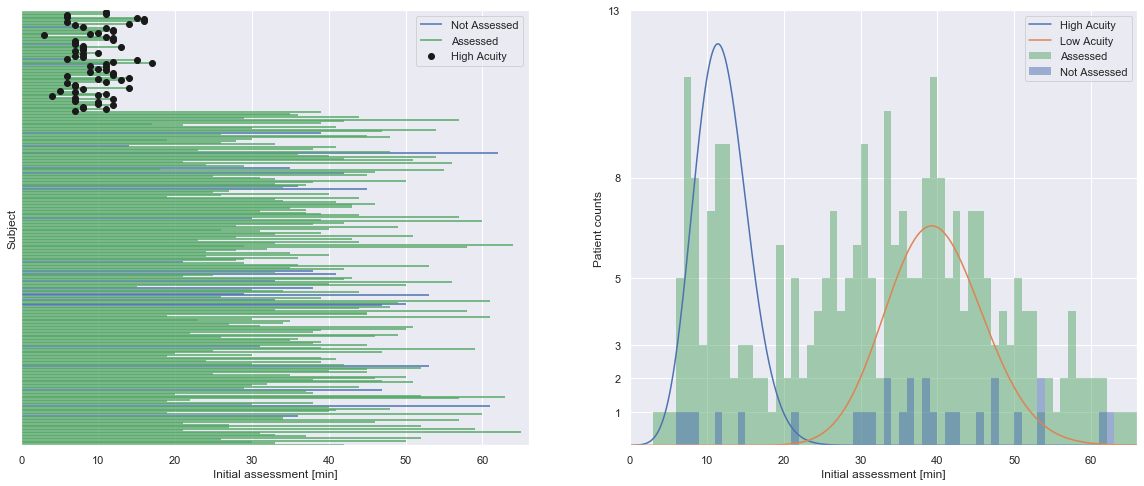

In [66]:
fig, (assess_ax, dist_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(20, 8))

blue, _, red = sns.color_palette()[:3]
assess_ax.hlines(patients[df.assessment.values == 0], 0, df[df.assessment.values == 0].time, color=blue, label='Not Assessed')
assess_ax.hlines(patients[df.assessment.values == 1], 0, df[df.assessment.values == 1].time, color=red, label='Assessed')
assess_ax.scatter(df[df.acuity.values == 1].time, patients[df.acuity.values == 1], color='k', zorder=10, label='High Acuity')
assess_ax.set_xlim(left=0)
assess_ax.set_xlabel('Initial assessment [min]')
assess_ax.set_yticks([])
assess_ax.set_ylabel('Subject')
assess_ax.set_ylim(-0.25, n_patients + 0.25)
assess_ax.legend(loc='upper right');

dist_ax.hist(df[df.assessment == 1].time.values, bins=interval_bounds, color=red, alpha=0.5, lw=0, label='Assessed');
dist_ax.hist(df[df.assessment == 0].time.values, bins=interval_bounds, color=blue, alpha=0.5, lw=0, label='Not Assessed');
dist_ax.plot(x, norm_m*dist1, label="High Acuity")
dist_ax.plot(x, norm_m*dist2, label="Low Acuity")
dist_ax.set_xlim(0, interval_bounds[-1]);
dist_ax.set_xlabel('Initial assessment [min]');
dist_ax.set_yticks([1, 2, 3, 5, 8, 13]);
dist_ax.set_ylabel('Patient counts');
dist_ax.legend();

In [67]:
last_period = np.floor((df.time - 0.01) / interval_length).astype(int)

assessed = np.zeros((n_patients, n_intervals))
assessed[patients, last_period] = df.assessment

In [68]:
exposure = np.greater_equal.outer(df.time.values, interval_bounds[:-1]) * interval_length
exposure[patients, last_period] = df.time - interval_bounds[last_period]

In [69]:
SEED = 644567 # from random.org

In [70]:
with pm.Model() as model:

    lambda0 = pm.Gamma('lambda0', 0.01, 0.01, shape=n_intervals)

    beta = pm.Normal('beta', 0, sigma=100)

    lambda_ = pm.Deterministic('lambda_', T.outer(T.exp(beta * df.acuity), lambda0))
    mu = pm.Deterministic('mu', exposure * lambda_)
    
    # Data likelihood
    obs = pm.Poisson('obs', mu, observed=assessed)


In [71]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, progressbar=True )    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [lambda0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [72]:
base_hazard = trace['lambda0']
met_hazard = trace['lambda0'] * np.exp(np.atleast_2d(trace['beta']).T)

In [73]:
def cum_hazard(hazard):
    return (interval_length * hazard).cumsum(axis=-1)

def survival(hazard):
    return np.exp(-cum_hazard(hazard))

In [74]:
def plot_with_hpd(x, hazard, f, ax, color=None, label=None, alpha=0.05):
    mean = f(hazard.mean(axis=0))

    percentiles = 100 * np.array([alpha / 2., 1. - alpha / 2.])
    hpd = np.percentile(f(hazard), percentiles, axis=0)

    ax.fill_between(x, hpd[0], hpd[1], color=color, alpha=0.25)
    ax.step(x, mean, color=color, label=label);

In [75]:
from matplotlib.ticker import StrMethodFormatter
sns.set()
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)
pct_formatter = StrMethodFormatter('{x:.1%}')

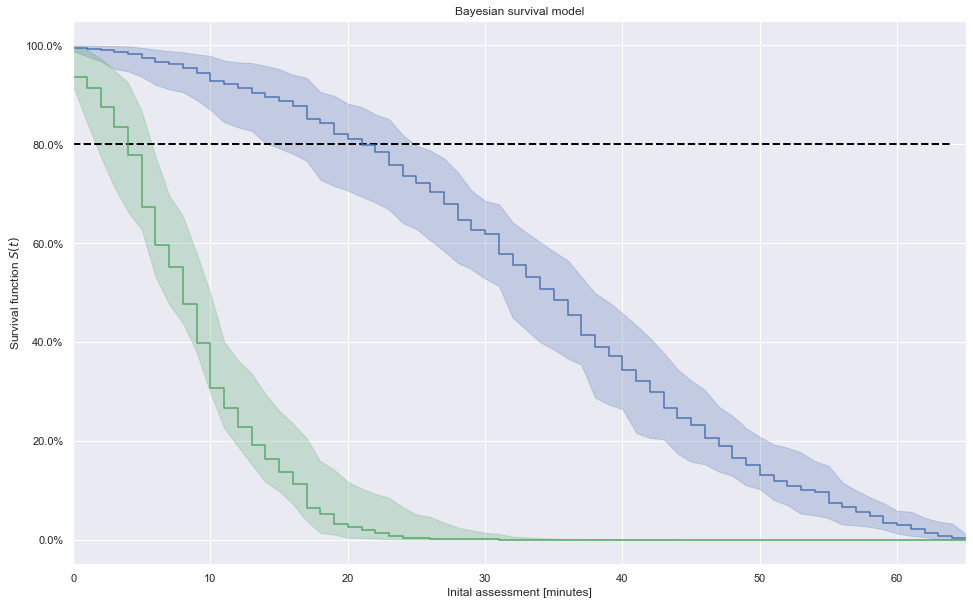

In [77]:
fig, surv_ax = plt.subplots(figsize=(16, 10))
surv_ax.plot(np.array(range(np.max(df['time'].values))), [0.8]*np.max(df['time'].values), '--', color='black',linewidth=2, label='80% Target')
plot_with_hpd(interval_bounds[:-1], base_hazard, survival, surv_ax, color=blue)
plot_with_hpd(interval_bounds[:-1], met_hazard, survival, surv_ax, color=red)
surv_ax.yaxis.set_major_formatter(pct_formatter);
surv_ax.set_xlim(0, df.time.max());
surv_ax.set_xlabel('Inital assessment [minutes]');
surv_ax.set_ylabel('Survival function $S(t)$');
surv_ax.set_title("Bayesian survival model");